
1. Simulate some panel data. We’ll do some analysis similar to the Eclipse Bug Report paper, https://arxiv.org/pdf/1803.04129.pdf, but without the DID piece. Specifically,
  * Simulate N units over T discrete time steps.
  * Add confounding through a variable Z  between treated and untreated units which is constant over time. That is, $Z = Z_i$, and not $Z_{it}$ (where $i$ is an index that runs over units, and $t$ runs over time steps). In particular ...
  * Add a time-varying causal state where $D^*$ (as we defined it in class) is caused by $Z_i$. It should be a binary treatment which turns on and stays on for each test unit ($D^* = 1$) at a different time, but never turns on for control units ($D^* = 0$)
  * Compute counterfactuals $Y^0_{it}$ and $Y^1_{it}$ which are caused by $Z_i$.
2. Use your counterfactuals to estimate the time series causal effect. Plot it, and explain from the data generating process why it's correct.
3. Create a propensity score model for $D*$.
4. Match units to estimate the ATT.
5. Estimate the expected counterfactuals for the test group: $E[Y^1_t |D=1]$ and $E[Y^0_t |D=1]$. You’ll have to be careful: since all the units treatments don’t turn on at the same time, you’ll want to mask out the treatment units in the $D_{it}=0$ state when you’re taking your averages. Numpy’s masked array object can be useful here, numpy.ma.array
6. Use the time series you estimated in (4) to estimate the time-varying ATT.


In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

Question 1

In [2]:
units = 5000 #N
time_steps = 52 #T

p_z = .5
z = np.random.binomial(1, p_z, size=units) #Z

p_d = .25 + z / 2
d = np.random.binomial(1, p_d, size=units) #Causal state

start = np.random.randint(1, 52, size=units) #Start time for causal state
delta = 5 #Treatment effect

#N x T array of causal state over time D_it which stays on for treatment and never activates for control
d_it = np.array([[0] * (start[index]) + [delta] * (52 - start[index]) for index in range(len(d))])

# taken from matrix_completion.ipynb
a_trend = np.arange(0, time_steps, 1)
Z1 = np.random.normal(size=units)
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(Z1, time_steps).reshape(time_steps, units).T
Y_0 = A_trend + A_indiv #Y_0

Y_1 = Y_0 + d_it #Y_1

d = d.reshape(5000, 1)
#Y = [Y_0[i] if d[i] == 0 else Y_1[i] for i in range(len(d))] #Y_0 if d == 0 ow Y_1
Y = (d==1)*Y_1 + (d==0)*Y_0

df = pd.DataFrame(Y)
df['d'] = d
df['Z'] = z
df['start'] = start

Question 2

Naive expected values, determined by the potential outcomes $Y_0, Y_1$

In [3]:
df_y0 = pd.DataFrame(Y_0)
df_y1 = pd.DataFrame(Y_1)

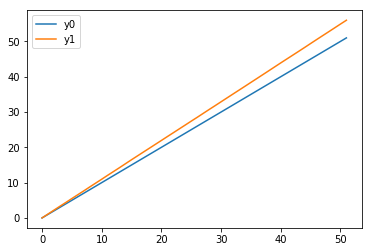

In [4]:
pd.DataFrame({'y0': df_y0.mean(), 'y1': df_y1.mean()}).plot()

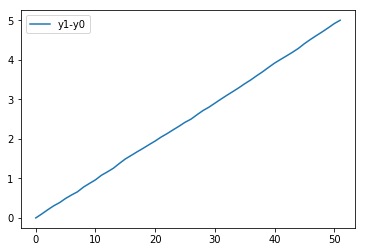

In [5]:
pd.DataFrame({'y1-y0': df_y1.mean() - df_y0.mean()}).plot()

At time $T=52$, the difference in $Y_1$ and $Y_0$ is given by:

In [6]:
df_y1.mean()[51] - df_y0.mean()[51]

4.999999999999972

The data generating process adds a constant delta = 5 to the treatment group, beginning at a variable start time and continuing until T = 52. As expected the difference in the potential outcomes $Y_0, Y_1$ after T time steps is equal to that delta.  
At time step $t$, the causal effect is equal to $\frac{5t}{52}$. We can reconstruct that from the data generating process as $\delta = 5$ times the expected proportion of units in the treatment state $\frac{t}{52}$.

Question 3

Construct a propensity score model using the causal states $d_{it}$.

In [7]:
from statsmodels.api import WLS, OLS
from sklearn.linear_model import LogisticRegression

In [8]:
var_list = [i for i in range(51)]

In [9]:
propensity_model = LogisticRegression(C=1e12)
propensity_model = propensity_model.fit(df[var_list], df['d'])
df['P_d1_t'] = propensity_model.predict_proba(df[var_list])[:, 1]

In [10]:
df[['d', 'P_d1_t']].head()

,d,P_d1_t
0,1,0.999554
1,1,0.999207
2,0,0.019754
3,0,0.020096
4,0,0.023119


Question 4

Construct weights from propensity scores as $w_{i, ATT} = \frac{p_i}{1 - p_i}$ if $d_i = 0$, 1 if $d_i = 1$.

In [11]:
df['wATT'] = (df['d'] == 1) * 1 + (df['d'] == 0) * (df['P_d1_t'] / (1 - df['P_d1_t']))

In [12]:
df['intercept'] = 1
model = WLS(df[51], df[['d', 'intercept']], weights=df['wATT'])
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     51   R-squared:                       0.334
Model:                            WLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                 2.929e+04
Date:                Sun, 16 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:18:46   Log-Likelihood:                -10169.
No. Observations:                5000   AIC:                         2.034e+04
Df Residuals:                    4998   BIC:                         2.035e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d              4.8727      0.028    171.133      0.000       4.817       4.929
intercept     51.1176      0.020   2537.053      0.000      51.078      51.157
==============================================================================
Omnibus:                      310.566   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1412.104
Skew:                           0.007   Prob(JB):                    2.32e-307
Kurtosis:                       5.603   Cond. No.                         13.4
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

The estimated ATT is the coefficient of $d = 4.8$, which is not far from the ATE $ = \delta = 5$.

Question 5

Y_1_est contains the measurement of the treatment, $Y | D = 1$  
d_it_1 contains the causal states of the treatment, $d_{it} | D=1$  
Y_1_est_ma is Y_1_est with $Y^1$ values masked, $Y^1 | D = 1$

In [13]:
Y_1_est = [Y[i] for i in range(len(d)) if d[i] == 1]
d_it_1 = [d_it[i] for i in range(len(d)) if d[i] == 1]
d_it_1_trt = [(1 - d_it[i] / delta) for i in range(len(d)) if d[i] == 1] #After d turns on, d_it = delta
Y_1_est_ma = ma.array(Y_1_est, mask=d_it_1)
Y_1_est_trt = ma.array(Y_1_est, mask=d_it_1_trt)

In [14]:
df_ctrl = pd.DataFrame(Y_1_est_ma)
df_trt = pd.DataFrame(Y_1_est_trt)

$E[Y^1|D = 1]$

In [15]:
df_trt.mean()

0           NaN
1      6.174678
2      7.207279
3      8.049802
4      9.031598
5     10.019210
6     10.995646
7     11.971338
8     12.994864
9     13.991142
10    14.978236
11    15.989830
12    16.991746
13    17.987072
14    18.986139
15    20.000751
16    20.979942
17    21.973593
18    22.969536
19    23.972907
20    24.966989
21    25.960479
22    26.956097
23    27.959336
24    28.955874
25    29.961292
26    30.966746
27    31.967391
28    32.975910
29    33.980656
30    34.975110
31    35.979994
32    36.981520
33    37.986154
34    38.990153
35    39.987576
36    40.991338
37    41.987165
38    42.989046
39    43.989112
40    44.984084
41    45.985068
42    46.987412
43    47.988907
44    48.986227
45    49.992779
46    50.994050
47    51.993027
48    52.989400
49    53.987361
50    54.987344
51    55.990291
dtype: float64

$E[Y^0|D = 1]$

In [16]:
df_ctrl.mean()

0     -0.009709
1      0.986946
2      1.981996
3      2.986613
4      3.986874
5      4.987100
6      5.989610
7      6.993050
8      7.989471
9      8.990117
10     9.993097
11    10.990413
12    11.989861
13    12.991333
14    13.991829
15    14.985915
16    15.994974
17    16.998536
18    18.001504
19    19.000559
20    20.005013
21    21.010682
22    22.015257
23    23.014831
24    24.020034
25    25.017380
26    26.013761
27    27.015434
28    28.007360
29    29.002444
30    30.011116
31    31.005644
32    32.004431
33    32.997549
34    33.990555
35    34.996010
36    35.987870
37    36.998429
38    37.993912
39    38.994174
40    40.013501
41    41.011451
42    42.003325
43    42.997231
44    44.014271
45    44.972236
46    45.956069
47    46.959634
48    48.003459
49    49.055894
50    50.122666
51          NaN
dtype: float64

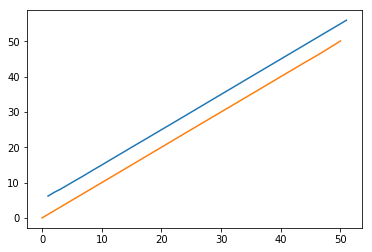

In [17]:
df_trt.mean().plot()
df_ctrl.mean().plot()

As expected, from the data generating process, there looks like a constant difference in the expected counterfactuals for the treatment group.

Question 6

In [18]:
ATT_est = df_trt.mean() - df_ctrl.mean()

The ATT at the final time step is:

In [19]:
ATT_est[50]

4.864678631615881

This ATT is about equal to that which we retrieved from propensity score matching earlier.  
I would expect that the estimated ATT converge as all units move into the treatment group.

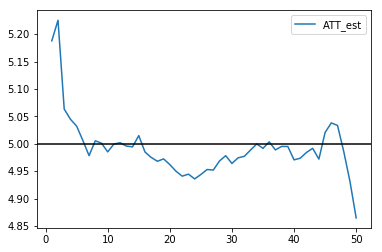

In [20]:
g = pd.DataFrame({'ATT_est': ATT_est}).plot()
g.axhline(y=5, color='black')

In [21]:
ATT_est

0          NaN
1     5.187731
2     5.225283
3     5.063188
4     5.044724
5     5.032110
6     5.006036
7     4.978288
8     5.005393
9     5.001025
10    4.985139
11    4.999417
12    5.001886
13    4.995739
14    4.994309
15    5.014836
16    4.984968
17    4.975057
18    4.968032
19    4.972348
20    4.961976
21    4.949796
22    4.940841
23    4.944505
24    4.935840
25    4.943911
26    4.952986
27    4.951957
28    4.968550
29    4.978212
30    4.963994
31    4.974350
32    4.977089
33    4.988605
34    4.999598
35    4.991566
36    5.003468
37    4.988736
38    4.995135
39    4.994938
40    4.970583
41    4.973617
42    4.984087
43    4.991676
44    4.971956
45    5.020544
46    5.037981
47    5.033393
48    4.985941
49    4.931467
50    4.864679
51         NaN
dtype: float64